In [495]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


## Spaceship Titanic Project by Calvin Chong
In this project, we are going to investigate the likelihood of whether people will be transported to another dimension through analysis of features and trends, and I will breakdown relevant findings and information. 

In [496]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
train_data.head()
train_data.shape

df1 = train_data #for testing and debugging 

In [497]:
train_data.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported'],
      dtype='object')

In [498]:
train_data.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


From the summary above, we can observe that there are missing values in all columns, as there is 8693 number of rows, but the counts do not match

Subsequently, we are able to infer that there are very few people who are spending money on the services such as RoomService, FoodCourt, ShoppingMall, Spa, VRDeck. 
We know this because up till the 50th percentile, the spending is still 0.0, which means that the lower 50% of spending is 0

This could perhaps have correlation with people who are transported to another dimension, as people who tend to spend more are generally more wealthy, and they may have access to better facilities

This could also be due to the fact that people in CryoSleep are unable to spend money at these facilities.

The large spending numbers, with max of 29813, and a min of 0 may cause the model to be confused, so we might need to apply a log transformation to these spending categories later.


In [499]:
train_data.describe(include = ["object","bool"])

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,VIP,Name,Transported
count,8693,8492,8476,8494,8511,8490,8493,8693
unique,8693,3,2,6560,3,2,8473,2
top,9280_02,Earth,False,G/734/S,TRAPPIST-1e,False,Anton Woody,True
freq,1,4602,5439,8,5915,8291,2,4378


From the summary of categorical features above, PassengerId does not have any missing values since the total number of training examples is 8693. Therefore, we can observe that the other features all include missing values, that we have to resolve later on.

PassengerId could provide us with hints on whether or not the passengers came on the spaceship together, or are families. We can split the PassengerId by the "_" to evaluate further later.

5439/8476 People were not placed in CryoSleep, which may have an effect of the likelihood of being Transported, and affects their spendings at the services facilities.

8291/8490 People are not VIP, which may have an effect of the likelihood of being Transported

There are 3 different destinations in total, with TRAPPIST-1e being the most popular. We will investigate whether the destination has an effect on likelihood of being Transported

There are also 3 different home planets, with Earth being the most popular. 

The feature Cabin takes the form of "deck/num/side", where side can be either P for "Port" or S for "Starboard", we will investigate this as well. 


In [500]:
train_data.isnull().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

## 1. Target Variable Distribution 

Target Variable Distribution helps us identify is our dataset is balanced (equal number of True/False)

This is important in classification tasks


<Axes: xlabel='Transported', ylabel='count'>

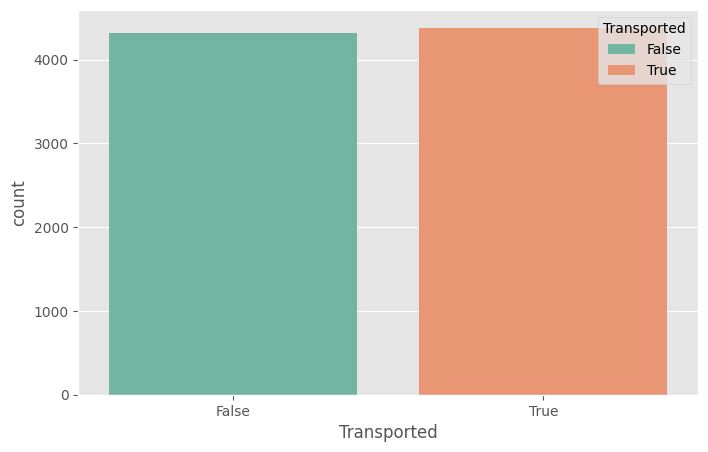

In [501]:
plt.figure(figsize=(8,5))
sns.countplot(x="Transported",hue = "Transported",data = train_data, palette = 'Set2')

As observed, we see that there is a balance between True and False for the target variable. This makes our job easier, as there is not need to perform special fixes like resampling or adjusting class weights during model training.

## 2. Numerical Feature Distributions

One way (and easier way) to visualise the distribution of numerical features is by using the inbuilt dataframe .hist() method 

df.hist(bins = ..., ) allows us to quickly visualise all the features within the df with the set amount of bins for each plot. however, this is less versatile and allows for less customisation

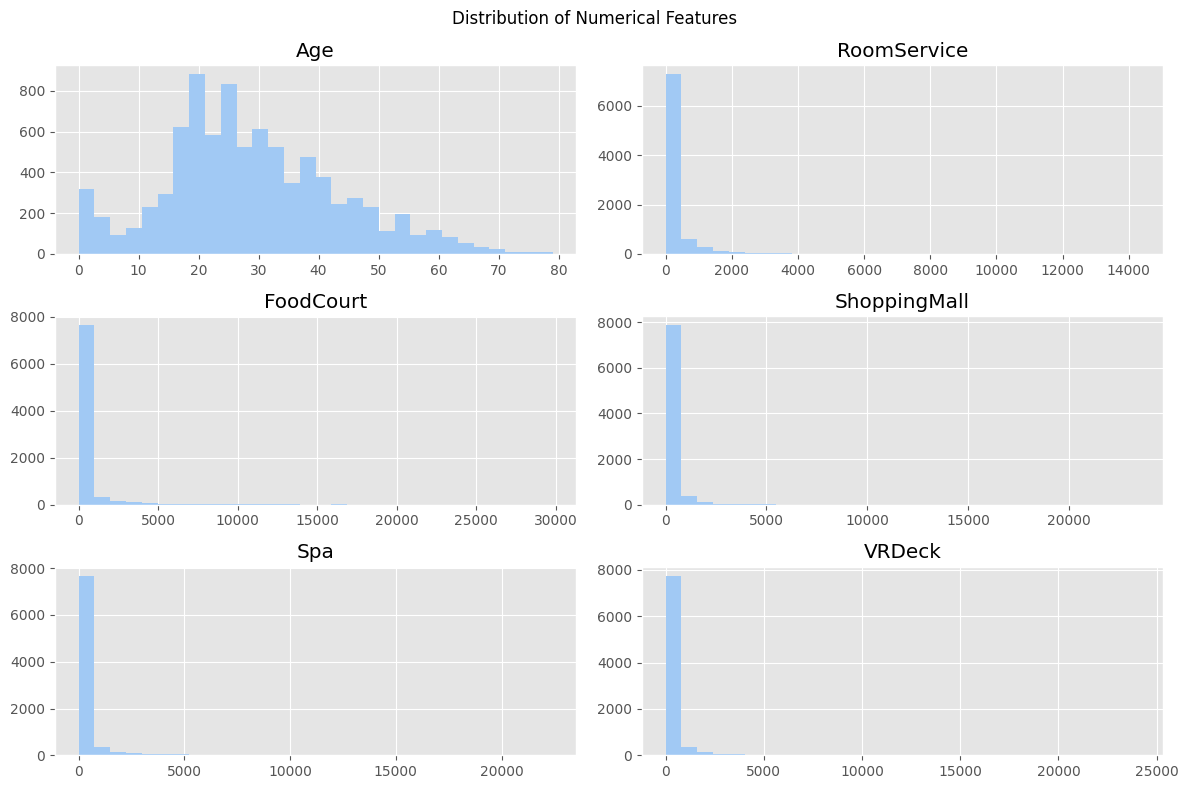

In [502]:
num_cols = train_data.select_dtypes(include=["int64","float64"]).columns
train_data[num_cols].hist(bins = 30, figsize = (12,8))
plt.suptitle("Distribution of Numerical Features")
plt.tight_layout()


It can be observed that the distribution of the feature 'Age' generally lies between 18-30. 

We can observe that spending related features are generally at 0, with most people spending nothing, either they are not able to afford it, or they are unable to (CryoSleep)


The second way (more difficult, but more commonly used) is using seaborn's histplot. 


In [503]:
# fig,axes = plt.subplots(nrows=3,ncols=3,figsize=(15,10))
# print(axes) ## axes is now a [3,3] matrix. we want to flatten axes to become a 1d list of 9 elements, so we can loop through it easily

# ax = axes.flatten()

# for i,col in enumerate(num_cols):
#     sns.histplot(data = train_data, x = col, kde = True, ax = ax[i])


## 3. Categorical Feature Distribution
We will be able to observe how many people belong into each category, such as CryoSleep, Destination, HomePlanet, etc. 

We will not be plotting columns with more than 15 unique values, as it will make the plot unreadable. 

In [504]:
cat_cols = train_data.select_dtypes(include=['object','bool']).columns.drop('Transported')
print(cat_cols)

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'VIP',
       'Name'],
      dtype='object')


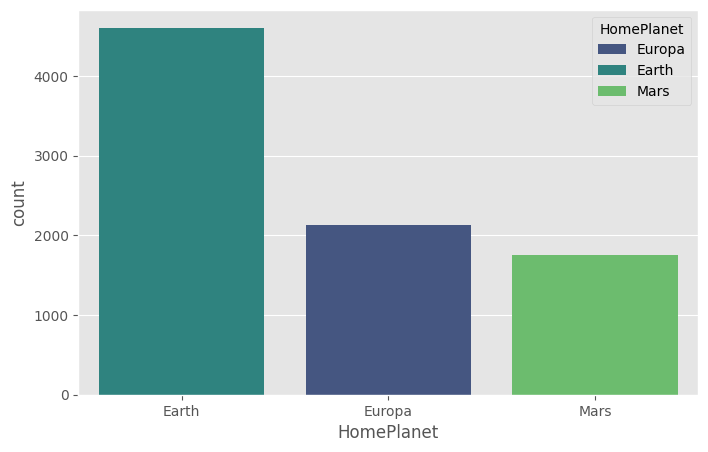

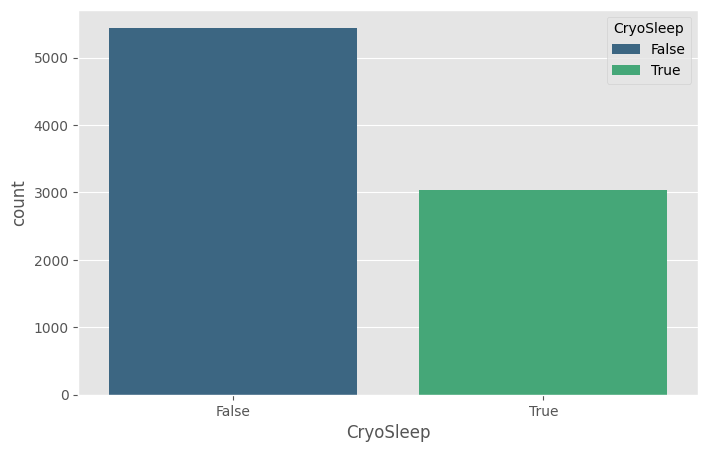

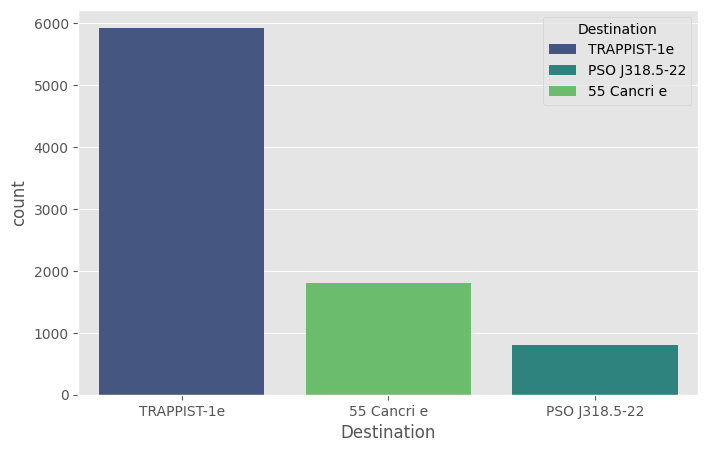

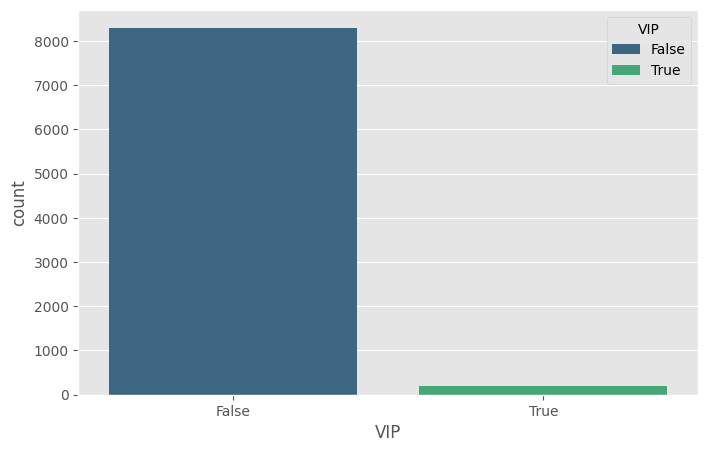

In [505]:
for col in cat_cols:
    if train_data[col].nunique() < 15:
        plt.figure(figsize = (8,5))
        sns.countplot(x=col,hue = col, data=train_data,palette = 'viridis',order = train_data[col].value_counts().index)

We can observe that most people on the spaceship came from the Planet Earth 

Half of them did not go to CryoSleep

Most of them are going to destination TRAPPIST-1e

And most of them are not VIPs

## 3. Correlation Analysis

We will conduct correlation analysis to find out whether there is correlation between: 

1. Numerical Features 

2. Outliers

3. Features vs Target

### 3.1 Numerical Features

We can evaluate the correlation between numerical features through using a correlation matrix heatmap


Text(0.5, 1.0, 'Correlation Matrix Between Numerical Features')

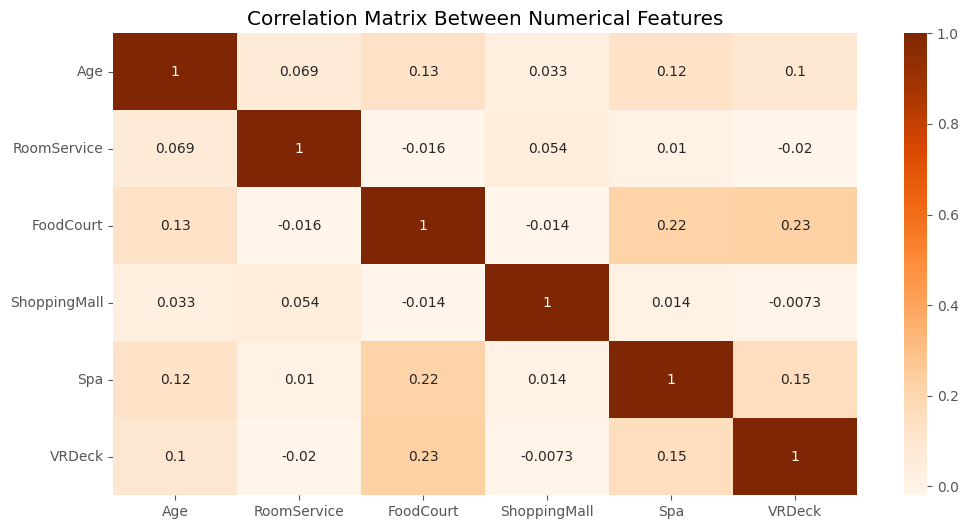

In [506]:
corr_matrix = train_data[num_cols].corr()

sns.heatmap(corr_matrix,annot = True, cmap = 'Oranges')
plt.title('Correlation Matrix Between Numerical Features')


 As observed, there isn't much correlation between the numerical features, with the highest correlation being FoodCourt and Spa at 0.22, and FoodCourt and VRDeck at 0.23

 These correlations are pretty small, so it might be safe to say that there isn't much correlation between then numerical features.

 

### 3.2 Outlier Detection

We will conduct the outlier detection to observe which features has significant outliers. Outliers can be found using boxplots

Why its useful:

- Significant Outliers can affect model performance, so it may be a good idea to cap or remove these outliers. 



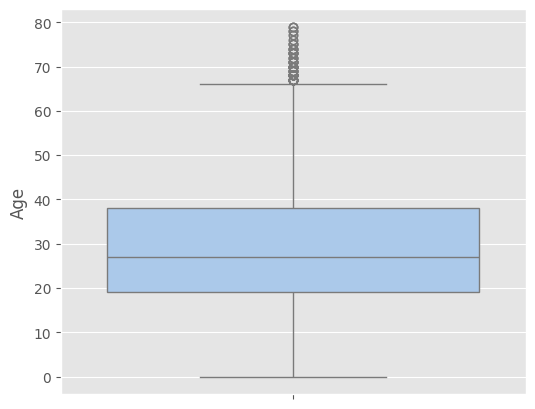

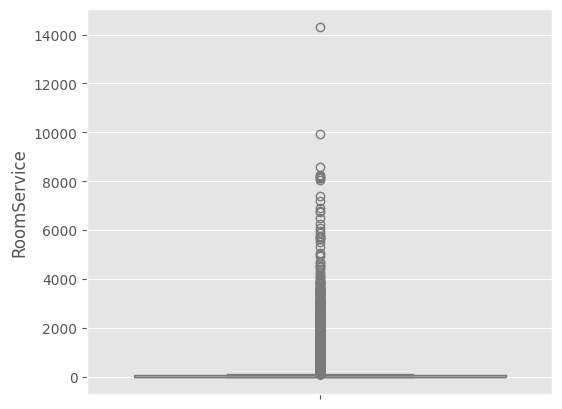

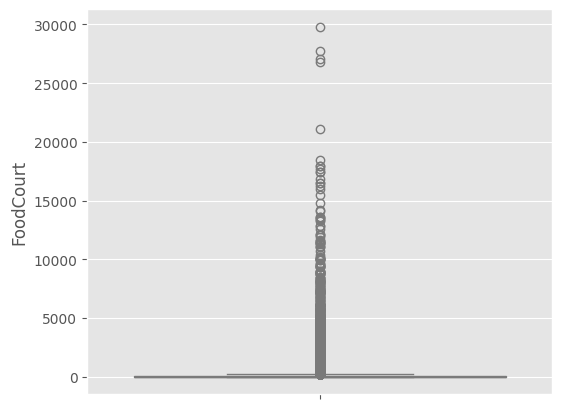

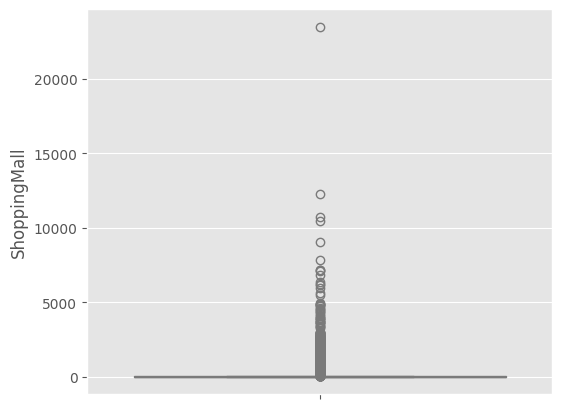

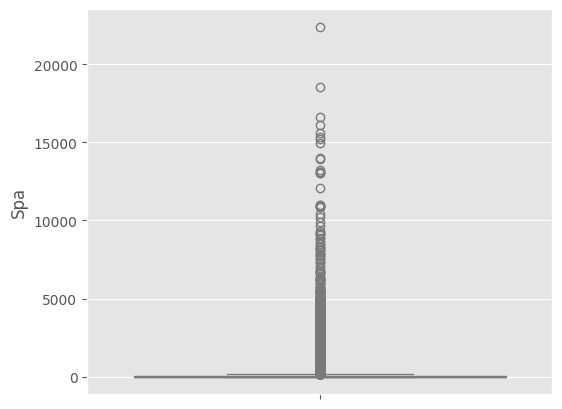

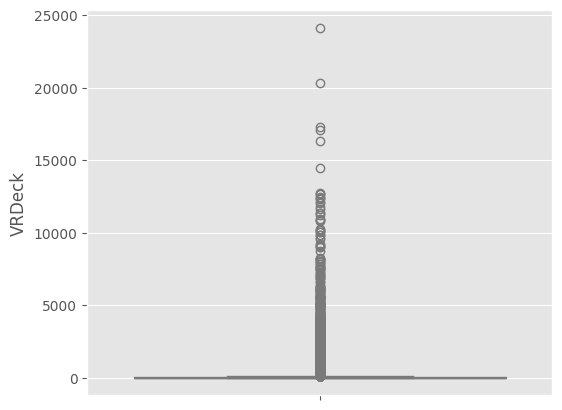

In [507]:
for col in num_cols:
    plt.figure(figsize = (6,5))
    sns.boxplot(data = train_data[col])

We see that while the code in building the boxplot works, there isnt really a need to make the boxplot this large. It would be a better idea to create subplots of 2 rows of 3 columns


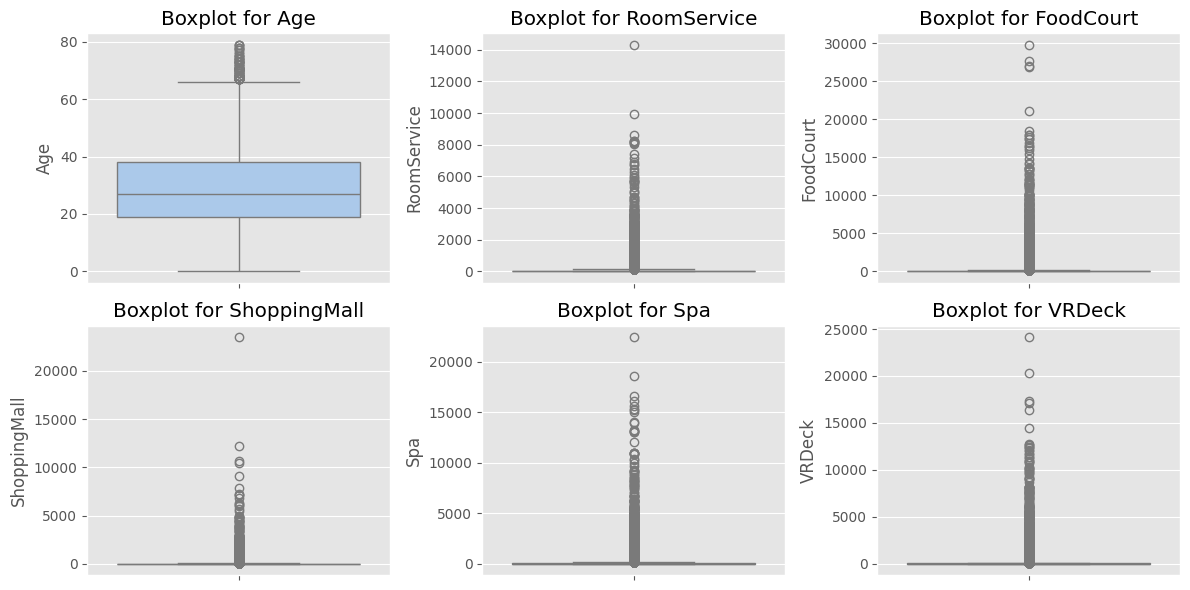

In [508]:
fig, ax = plt.subplots(nrows = 2,ncols = 3)
axes = ax.flatten()
for i,col in enumerate(num_cols):
    sns.boxplot(data = train_data[col], ax = axes[i])
    axes[i].set_title(f"Boxplot for {col}")
#Note: we don't use plt.title(f'Boxplot'...) because plt.title sets a global title which applies to the entire figure
#using .set_title allows us to set the title to the respective features
plt.tight_layout()


As expected, the average age for passengers is around 18-40 with outliers at the 70-80 range. 
The average spending for facilities is 0, but there are a few passengers who spent alot, showing up as outliers. 

### 3.3 Feature vs Target 

We will plot a histogram of all the numerical features against the Target, to observe any correlations that may appear. 

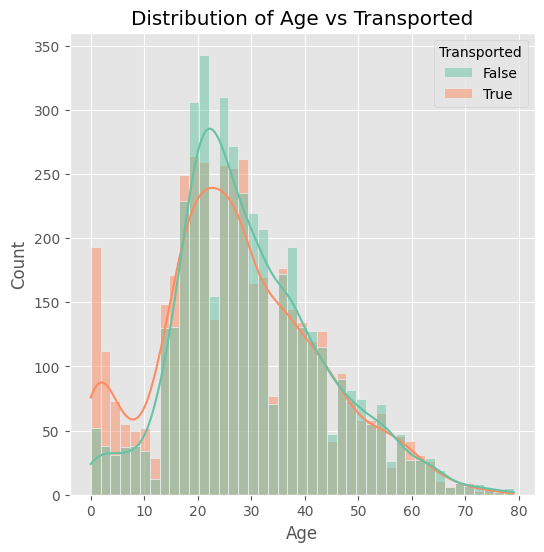

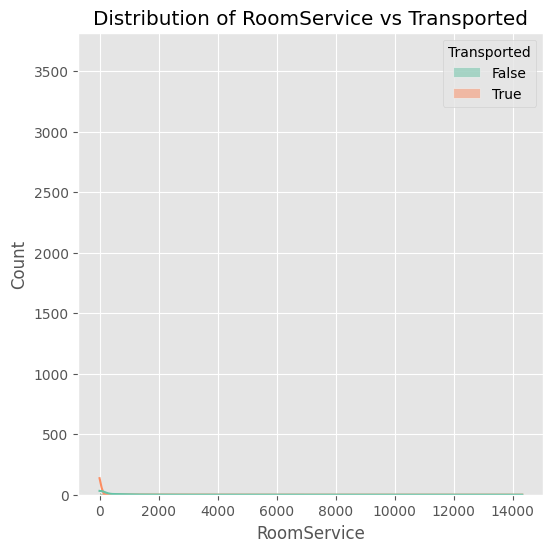

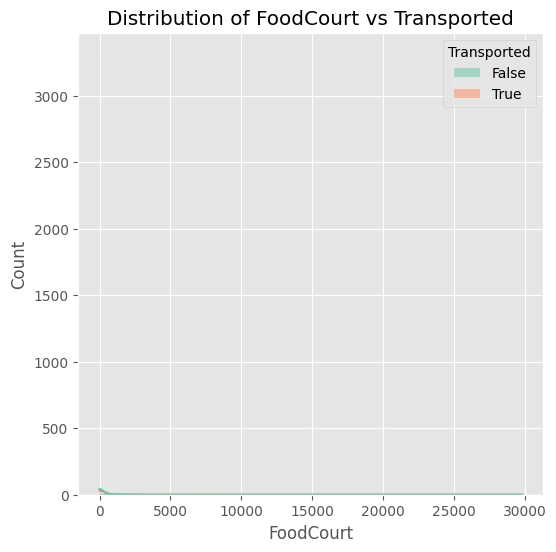

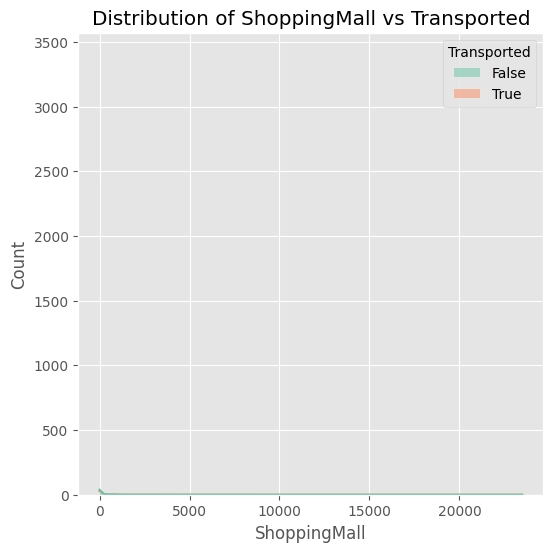

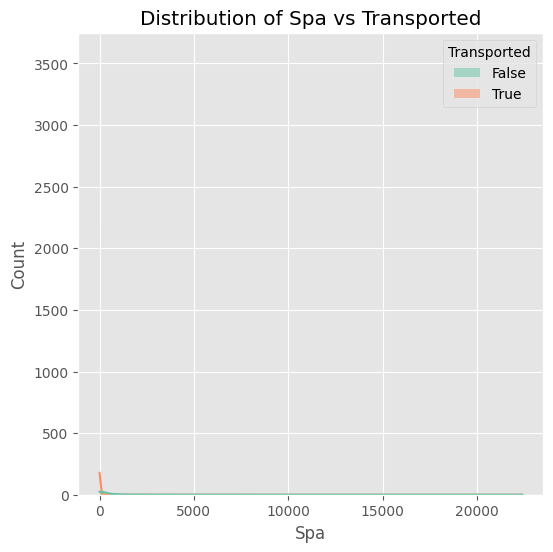

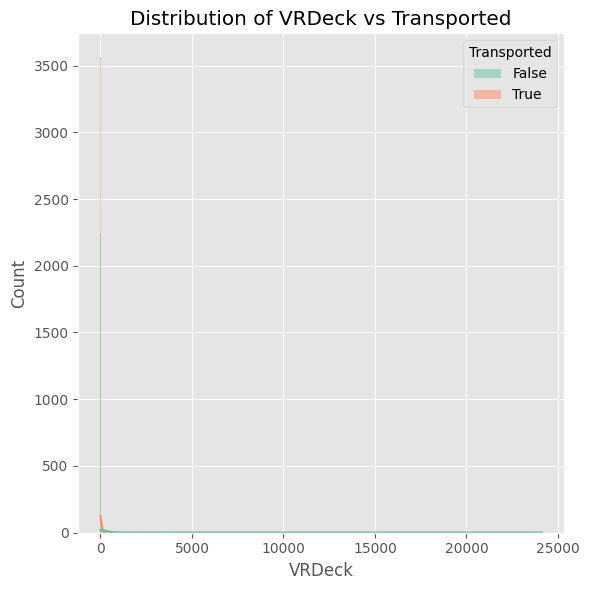

In [509]:
for col in num_cols:
    plt.figure(figsize=(6,6))
    sns.histplot(x = col, data = train_data,hue = 'Transported',palette = 'Set2',kde = True)
    plt.title(f'Distribution of {col} vs Transported')

plt.tight_layout()


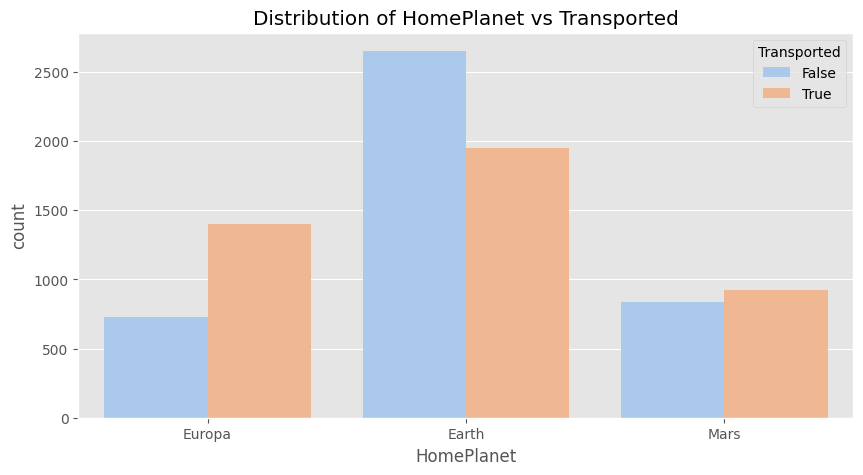

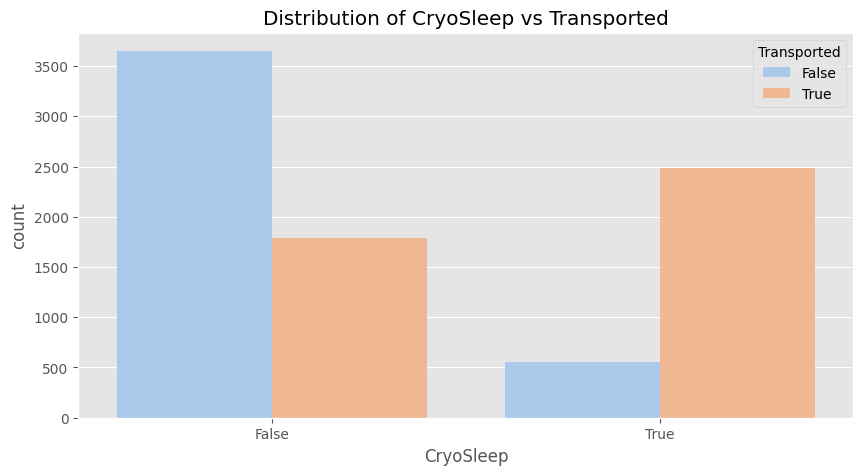

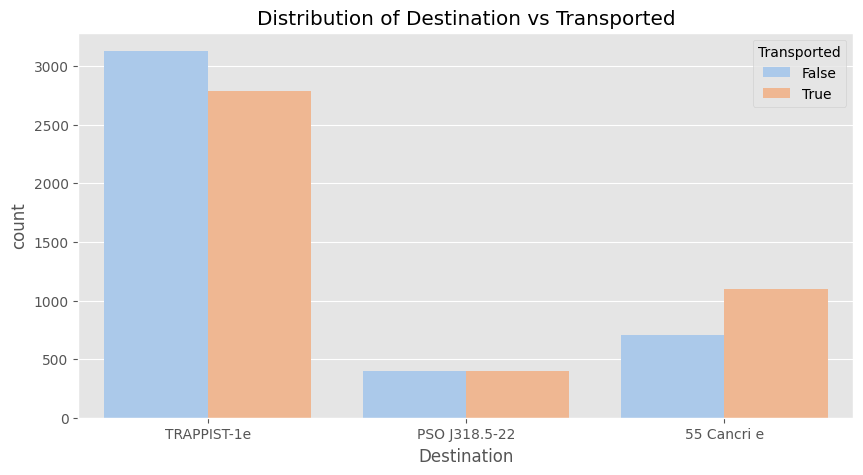

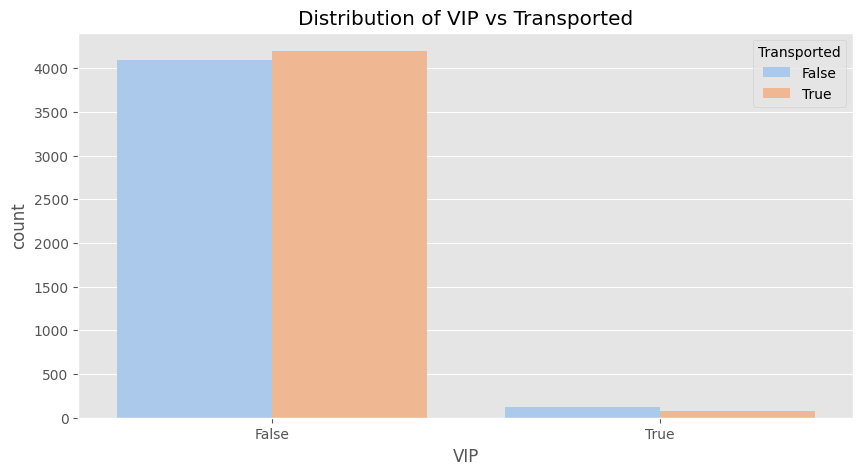

In [510]:
for col in cat_cols:
    if train_data[col].nunique() < 10:
        plt.figure(figsize=(10,5))
        sns.countplot(x = col, data = train_data, hue = 'Transported')
        plt.title(f'Distribution of {col} vs Transported')

    

### Numerical Analysis
- From the distribution plots for numerical features, only the 'Age' plot stands out. The other plots are barely visible because most of the values are distributed at 0. 

- From the 'Age' plot, we can see that younger people, aged below 20, are more likely to be transported. 


### Categorical Analysis
- From the distribution plots for categorical features, we are able to derive more information. 

- It appears that people from the HomePlanet Europa and Mars have a higher chance of being transported, as the number of people who are transported is larger than those who did not get transported. 

- A very large number of people who were in CryoSleep were transported, so this is definitely a feature that has a significant amount of weight on the likelihood. 

- Lastly, it appears that having destination set to 55 Cancri-e will result in a higher chance of being transported as well. 

- There isn't a significant amount of correlation between being a VIP and being transported. 

## 4. Performing analysis on Cabin and PassengerId

Cabin and PassengerId is unique as they are formatted as "codes" that have a specific meaning. 

PassengerId is formatted as "xxxx_gg", where xxxx is the group the passenger is travelling with, and gg is the their number in that group. This could provide us with information on whether or not travelling in groups is more likely to be transported

The feature Cabin takes the form of "deck/num/side", where side can be either P for "Port" or S for "Starboard", we will investigate this as well. 


In [511]:
def splitting_feature(df):
    df = df.copy()
    df['Passenger_Group'] = df['PassengerId'].str.split('_').str[0]


    df['Cabin_Deck'] = df['Cabin'].str.split('/').str[0]
    df['Cabin_Num'] = df['Cabin'].str.split('/').str[1]
    df['Cabin_Side'] = df['Cabin'].str.split('/').str[-1]
    
    return df


train_data = splitting_feature(train_data)
train_data.head()



,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Passenger_Group,Cabin_Deck,Cabin_Num,Cabin_Side
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,0001,B,0,P
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,0002,F,0,S
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,0003,A,0,S
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,0003,A,0,S
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,0004,F,1,S


In [512]:
train_data['Passenger_Group'].describe(include = 'object')

count     8693
unique    6217
top       9081
freq         8
Name: Passenger_Group, dtype: object

Explanation of the code below:

At its very core, value_counts() returns the index as the "name" of the instance, and value as the number of occurence of that "name"

group_size returns a Pandas Series with the Passenger_Group and its number of occurrence (run code below for output)

group_size_distribution uses another instance of value_counts() to return the "name" as the index > which in this case is the value in group_size >> "name" being "8", "1", etc

value will be the number of occurrence of that name. As such, the output will be index: Frequency of each Passenger_Group value: number of occurrences

In [513]:
group_size = train_data['Passenger_Group'].value_counts()
group_size_distribution = group_size.value_counts()
print(group_size)
print(group_size_distribution)

Passenger_Group
9081    8
4005    8
8988    8
5133    8
4256    8
       ..
0022    1
0016    1
0015    1
0014    1
0012    1
Name: count, Length: 6217, dtype: int64
count
1    4805
2     841
3     340
4     103
5      53
7      33
6      29
8      13
Name: count, dtype: int64


Text(0.5, 1.0, 'Distribution of Group Sizes of Passengers according to PassengerId')

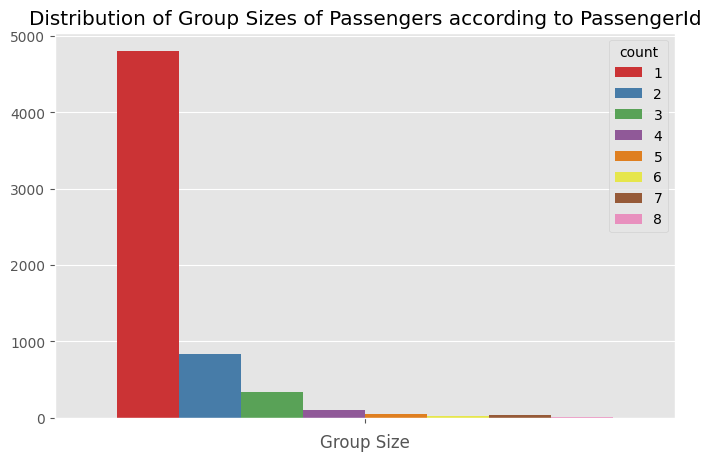

In [514]:
plt.figure(figsize = (8,5))
sns.barplot(hue = group_size_distribution.index,y = group_size_distribution.values, palette = "Set1")
plt.xlabel('Group Size')
plt.title('Distribution of Group Sizes of Passengers according to PassengerId')

Explanation of Code below:

We already know that group_size contains a pandas series containing index of "Passenger_Group" labels, and value of its number of occurrences

We want to create a new column GroupSize, that contains the number of occurences of each passenger_group. 

train_data['Passenger_Group'].map(group_size) > .map() will take the INDEX of group_size (in this case it is the Passenger_groups), and will match with the values in "Passenger_Group". 

If a match is found, then the new column GroupSize will take on the VALUE of that group_size index. 

We do this so that we are able to use a countplot >> countplot will give you the "count" of each value of GroupSize (1,2,3,8,etc).

In [515]:
train_data['GroupSize'] = train_data['Passenger_Group'].map(group_size) #group_size is the passsenger_group.value_counts() > index of the group number, and count of the frequency of occurrence
#
train_data['GroupSize']

0       1
1       1
2       2
3       2
4       1
       ..
8688    1
8689    1
8690    1
8691    2
8692    2
Name: GroupSize, Length: 8693, dtype: int64

<Axes: xlabel='GroupSize', ylabel='count'>

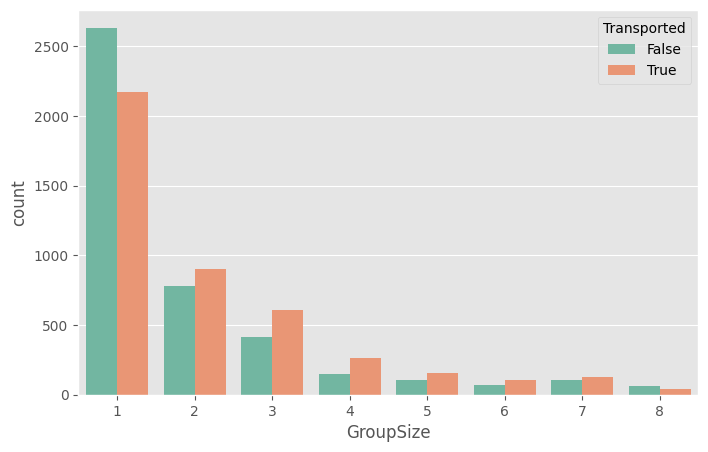

In [516]:
plt.figure(figsize=(8,5))
sns.countplot(data = train_data,x='GroupSize',hue = 'Transported',palette = "Set2")

Finally, we can observe that most people travelled Solo, and the likelihood of being transported is greater when travelling in a group.

Next, we will move on to observing the effects of our newly created columns: Cabin

The more important parts of Cabin would be Deck and Side, as Num is just a arbitrary number for each deck

In [517]:
train_data['Cabin_Deck'].value_counts()



Cabin_Deck
F    2794
G    2559
E     876
B     779
C     747
D     478
A     256
T       5
Name: count, dtype: int64

<Axes: xlabel='Cabin_Deck', ylabel='count'>

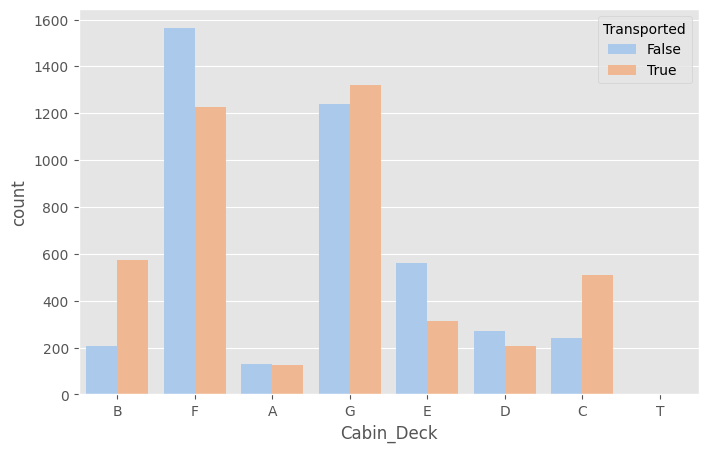

In [518]:
plt.figure(figsize=(8,5))
sns.countplot(x='Cabin_Deck',data = train_data, hue = 'Transported')


From the plot above, we observe that most people belonged to the F and G Deck. The rate of being transported was significantly higher in the decks B, G and C. 

There were only 5 occurrences of deck T, most likely being a special deck. Let's evaluate how many of these 5 occurences got transported. 


In [519]:
T_transported = train_data[(train_data['Cabin_Deck'] == "T") & (train_data['Transported'] == 0)] #set transported == 0 if we want to find NOT transported, 1 to find Transported
print(T_transported.shape[0]) #T_transported returns the entire row where the two conditions above are met. .shape will return the dimensions of the row, and .shape[0] will return the exact number of occurences


4


Lets perform the same analysis for Cabin Side

<Axes: xlabel='Cabin_Side', ylabel='count'>

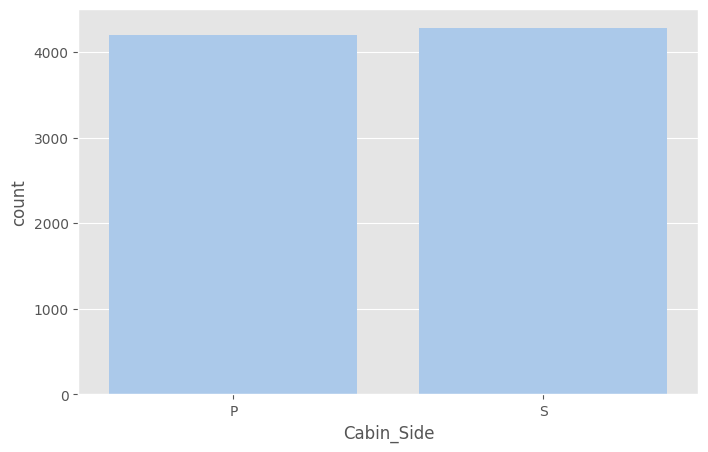

In [520]:
plt.figure(figsize = (8,5))
sns.countplot(x='Cabin_Side',data = train_data)

<Axes: xlabel='Cabin_Side', ylabel='count'>

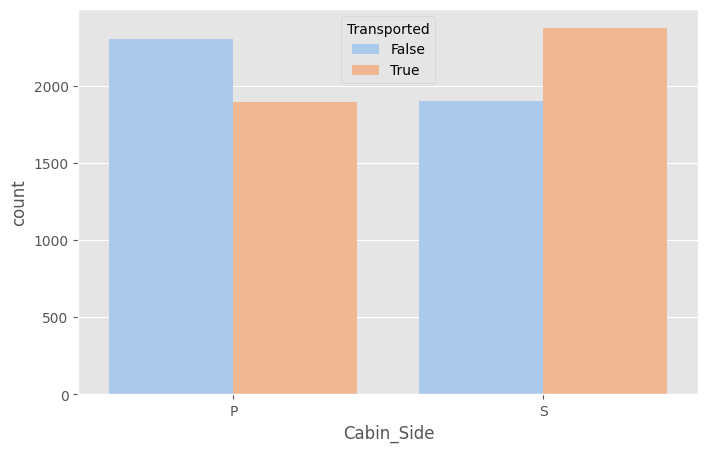

In [521]:
plt.figure(figsize = (8,5))
sns.countplot(x='Cabin_Side',data = train_data, hue = "Transported")

From the plot above, we can see that cabin side S has a higher rate of being Transported, though the difference is not huge.

## 5. Final Thoughts on Analysis

Through our EDA, we realise that several features may be more impactful on the outcome of being transported or not. Features like CabinDeck, GroupSize, Destination, HomePlanet, etc. We can also sum up all the spendings into a single variable, as these spending features have the same range (all having a median of 0, high outlier spending, etc). As such, we will train our models based on the findings that we have obtained. 

In [522]:
facilities = ['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']

train_data['Spending'] = train_data[facilities].sum(axis=1)

features = ['HomePlanet','CryoSleep','Cabin_Deck','Cabin_Side','Destination',
            'Age','VIP','Spending','GroupSize']

x_data = train_data[features]
y_data = train_data['Transported']

x_data.head()




,HomePlanet,CryoSleep,Cabin_Deck,Cabin_Side,Destination,Age,VIP,Spending,GroupSize
0,Europa,False,B,P,TRAPPIST-1e,39.0,False,0.0,1
1,Earth,False,F,S,TRAPPIST-1e,24.0,False,736.0,1
2,Europa,False,A,S,TRAPPIST-1e,58.0,True,10383.0,2
3,Europa,False,A,S,TRAPPIST-1e,33.0,False,5176.0,2
4,Earth,False,F,S,TRAPPIST-1e,16.0,False,1091.0,1


It is to be noted that we have yet to resolve the issue of missing values. We will build two pipelines (one for numerical, one for categorical) to fill in missing values. 

For numerical features, we will also apply a scaling function in order to normalise the data

For categorical features, we will also apply a one-hot encoding process in order to convert the categorical features to "numerical"



In [523]:
train_data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Passenger_Group,Cabin_Deck,Cabin_Num,Cabin_Side,GroupSize,Spending
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,0001,B,0,P,1,0.0
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,0002,F,0,S,1,736.0
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,0003,A,0,S,2,10383.0
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,0003,A,0,S,2,5176.0
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,0004,F,1,S,1,1091.0


In [ ]:
#features = ['HomePlanet','CryoSleep','Cabin_Deck','Cabin_Side','Destination',
#           'Age','VIP','Spending','GroupSize']

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import FunctionTransformer



num_features = ['Age','Spending','GroupSize']
num_input = [("imputer",SimpleImputer(strategy="median")),("scaler",StandardScaler())]
num_transform = Pipeline(num_input)


cat_features = ['HomePlanet','CryoSleep','Cabin_Deck','Cabin_Side','Destination','VIP']
cat_input = [("imputer1",SimpleImputer(strategy="most_frequent")),("one_hot",OneHotEncoder())]
cat_transform = Pipeline(cat_input)

preprocessor = ColumnTransformer(
    transformers = [
        ('num',num_transform,num_features),
        ("cat",cat_transform, cat_features)
    ]
)

model = Pipeline (steps = [
    ('preprocessor',preprocessor),
    ("logreg",LogisticRegression(random_state = 0))
])






0       False
1        True
2       False
3       False
4        True
        ...  
8688    False
8689    False
8690     True
8691    False
8692     True
Name: Transported, Length: 8693, dtype: bool


In [525]:
# x_train,y_train,x_test,y_test = train_test_split(x_data,y_data,test_size = 0.2, random_state = 0)
# print(y_data.shape)
print(y_data)
model.fit(x_data,y_data)

0       False
1        True
2       False
3       False
4        True
        ...  
8688    False
8689    False
8690     True
8691    False
8692     True
Name: Transported, Length: 8693, dtype: bool


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Spending',
                                                   'GroupSize']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer1',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('one_hot',
                                                                   OneHotEncoder())]),
                                                  ['HomePlanet', 'CryoSleep',
                                                   'Cabin_Deck', 'Cabin_Side',
                                                   'Destination', 'VIP'])])),
                ('logreg', LogisticRegression(random_state=0))])

Now, we want to predict the output using our test_data. However, we have to repeat the steps above and apply them on our test_data, which may take some time. Another way would be to create a function that includes all the steps we have applied on the train_data, and insert it into the Pipeline.

I will keep the steps above for step by step clarity, but note that it is a more efficient and better practice to always create a function when pre-processing data.

In [535]:

def clean_data(df):
    df = df.copy()
    #1. Split PassengerId into Passenger Group > then find Group_size from Passenger_Group
    df['Passenger_Group'] = df['PassengerId'].str.split('_').str[0]
    group_size = df['Passenger_Group'].value_counts()

    df['GroupSize'] = df['Passenger_Group'].map(group_size)

    #2. Split Cabin into Deck/Num/Side

    df['Cabin_Deck'] = df['Cabin'].str.split('/').str[0]
    df['Cabin_Side'] = df['Cabin'].str.split('/').str[-1]

    #3. Sum up Spending into a single Feature (Spending)
    facilities = ['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']
    df['Spending'] = df[facilities].sum(axis=1)

    return df

df_cleaned =  clean_data(df1)

x_submission = clean_data(test_data)
x_submission.head()    

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Passenger_Group,GroupSize,Cabin_Deck,Cabin_Side,Spending
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning,0013,1,G,S,0.0
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers,0018,1,F,S,2832.0
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus,0019,1,C,S,0.0
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter,0021,1,C,S,7418.0
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez,0023,1,F,S,645.0


In [543]:
#4. Identify Features that are Important for the Model 
features = ['HomePlanet','CryoSleep','Destination','Age','Spending','GroupSize','Cabin_Deck','Cabin_Side','VIP']


x_test = x_submission[features]
prediction = model.predict(x_test)

output = pd.DataFrame({"PassengerId":x_submission['PassengerId'],"Transported":prediction})

output.head()

output.to_csv("spaceship_titanic submission 2.csv",index = False)